# Training a CNN on the CIFAR-10 dataset

#### Types of datasets when working with classifiers.
- Image datasets
- Text datasets
- Audio datasets

#### Data conversion / preprocessing.
> Use a python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor

#### Packages generally used.
- Image datasets: Pillow, OpenCV
- Text datasets: NLTK, SpaCy
- Audio datasets: Librosa, SciPy

### CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

<img title="CIFAR10" alt="CIFAR10 Classes" src="images/cifar-classes.png">

### Traing an image classifier for CIFAR-10 dataset

1. Load and normalize the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
is_cuda = torch.cuda.is_available()
is_mps = torch.backends.mps.is_available()

# If we have a GPU available, we'll set our device to GPU. 
# We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
elif is_mps:
    device = torch.device("mps")
    print("MPS is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# Transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


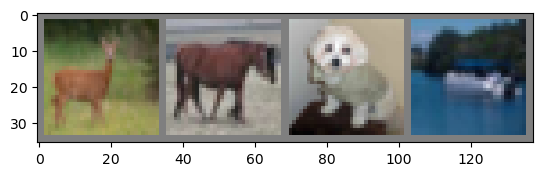

deer  horse dog   ship 


In [4]:
# Print training images
import matplotlib.pyplot as plt
import numpy as np

# Function to show image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a random training image
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Plot image
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = CNNet().to(device)

### 3. Define loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 4. Train the Network

In [7]:
epochs = 2
for epoch in range(epochs):
    loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # list of [inputs, ground truth labels]
        inputs, gt_labels = data[0].to(device), data[1].to(device)

        # reset parameter gradients
        optimizer.zero_grad()

        # get predictions
        predictions = model(inputs)
        # calculate loss
        loss = criterion(predictions, gt_labels)
        # backpropagate
        loss.backward()
        # update weights
        optimizer.step()

        # print loss
        loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss / 2000:.3f}')
            loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.002
[1,  4000] loss: 0.002
[1,  6000] loss: 0.001
[1,  8000] loss: 0.002
[1, 10000] loss: 0.002
[1, 12000] loss: 0.002
[2,  2000] loss: 0.001
[2,  4000] loss: 0.001
[2,  6000] loss: 0.001
[2,  8000] loss: 0.001
[2, 10000] loss: 0.002
[2, 12000] loss: 0.002
Finished Training


### Save the mode

In [8]:
PATH = "./models/cifar_net.pth"
torch.save(model.state_dict(), PATH)

### 5. Test the model on test data

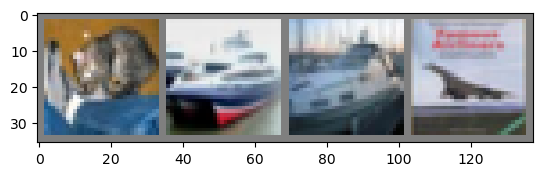

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
test_images, gt_labels = next(dataiter)

#print images

imshow(torchvision.utils.make_grid(test_images))
print('GroundTruth: ', ' '.join('%5s' % classes[gt_labels[j]] for j in range(4)))

In [11]:
test_predictions = model(test_images.to(device))

In [12]:
_, predicted = torch.max(test_predictions, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [13]:
# dictionary to store predictions of each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# since prediction no gradient are needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        predictions = model(images)
        _, predictions = torch.max(predictions, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.2 %
Accuracy for class: car   is 65.2 %
Accuracy for class: bird  is 23.6 %
Accuracy for class: cat   is 30.7 %
Accuracy for class: deer  is 56.7 %
Accuracy for class: dog   is 39.5 %
Accuracy for class: frog  is 77.8 %
Accuracy for class: horse is 63.3 %
Accuracy for class: ship  is 76.4 %
Accuracy for class: truck is 62.3 %
